# Image Captioning



Aşağıdaki örnek gibi bir görüntü verildiğinde, amacımız "Büyük bir dalga yakalayan sörfçü." şeklinde bir altyazı oluşturmaktır.

<div>
<img src="https://upload.wikimedia.org/wikipedia/commons/d/db/Surfing_in_Hawaii.jpg" width="500"/>
</div>

Bu not defteri uçtan-uca bir görüntü altyazılama için 2 adet model içerir. Not defterini çalıştırdığınızda, [MS-COCO](http://cocodataset.org/#home) veri kümesi indirilir, önceden eğitilmiş (pre-trained) bir CNN modeli kullanılarak görüntü alt kümesinden öznitelikler çıkarılır, kodlayıcı-kod çözücü modelleri eğitilebilir ve eğitilen modeli kullanarak yeni görüntüler üzerinde resim altyazıları oluşturulabilir. Bu not defterinde, eğitilen modeller nispeten küçük miktarda veri üzerinde eğitilmiştir: 

— yaklaşık 6.000 görüntü için 30.000 altyazı vardır. 



## Utils

In [ ]:
%%capture
!pip install "git+https://github.com/salaniz/pycocoevalcap.git"

import tensorflow as tf
from nltk.translate.bleu_score import sentence_bleu
from pycocoevalcap.tokenizer.ptbtokenizer import PTBTokenizer
from pycocoevalcap.bleu.bleu import Bleu
from pycocoevalcap.meteor.meteor import Meteor
from pycocoevalcap.rouge.rouge import Rouge
from pycocoevalcap.cider.cider import Cider
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import collections
import random
import numpy as np
import os
import time
import json
from PIL import Image
from tabulate import tabulate
import warnings
warnings.filterwarnings("ignore")

In [ ]:
def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
    return pos * angle_rates

def positional_encoding_1d(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                            np.arange(d_model)[np.newaxis, :],
                            d_model)

    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

    pos_encoding = angle_rads[np.newaxis, ...]

    return tf.cast(pos_encoding, dtype=tf.float32)

def positional_encoding_2d(row, col, d_model):
    assert d_model % 2 == 0

    row_pos = np.repeat(np.arange(row),col)[:,np.newaxis]
    col_pos = np.repeat(np.expand_dims(np.arange(col),0),row,axis=0).reshape(-1,1)
    angle_rads_row = get_angles(row_pos,np.arange(d_model//2)[np.newaxis,:],d_model//2)
    angle_rads_col = get_angles(col_pos,np.arange(d_model//2)[np.newaxis,:],d_model//2)

    angle_rads_row[:, 0::2] = np.sin(angle_rads_row[:, 0::2])
    angle_rads_row[:, 1::2] = np.cos(angle_rads_row[:, 1::2])
    angle_rads_col[:, 0::2] = np.sin(angle_rads_col[:, 0::2])
    angle_rads_col[:, 1::2] = np.cos(angle_rads_col[:, 1::2])
    pos_encoding = np.concatenate([angle_rads_row,angle_rads_col],axis=1)[np.newaxis, ...]

    return tf.cast(pos_encoding, dtype=tf.float32)


def create_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

def create_look_ahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask  


def scaled_dot_product_attention(q, k, v, mask):
    """
    Calculate the attention weights.
    q, k, v must have matching leading dimensions.
    k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
    The mask has different shapes depending on its type(padding or look ahead) 
    but it must be broadcastable for addition.

    Parameters
    ----------
    q: query shape == (..., seq_len_q, depth)
    k: key shape == (..., seq_len_k, depth)
    v: value shape == (..., seq_len_v, depth_v)
    mask: Float tensor with shape broadcastable 
            to (..., seq_len_q, seq_len_k). 
            Defaults to None.

    Returns
    ----------
    output, attention_weights
    """
    matmul_qk = tf.matmul(q, k, transpose_b=True)  

    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

    if mask is not None:
        scaled_attention_logits += (mask * -1e9)  

    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  

    output = tf.matmul(attention_weights, v) 

    return output, attention_weights


def point_wise_feed_forward_network(d_model, dff):
  return tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'), 
      tf.keras.layers.Dense(d_model)  
  ])


def create_masks_decoder(tar):
    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    dec_target_padding_mask = create_padding_mask(tar)
    combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)
    return combined_mask

## Download and prepare the MS-COCO dataset

Modelleri eğitmek için [MS-COCO veri kümesi](http://cocodataset.org/#home) kullanılmıştır. Veri kümesi, her biri en az 5 farklı görüntü altyazısına sahip 82.000'den fazla görüntü içerir. Aşağıdaki kod veri kümesini otomatik olarak indirir ve ayıklar.



In [ ]:
!git clone https://github.com/giddyyupp/turkish-image-captioning.git

Cloning into 'turkish-image-captioning'...
remote: Enumerating objects: 42, done.
remote: Total 42 (delta 0), reused 0 (delta 0), pack-reused 42
Unpacking objects: 100% (42/42), done.


In [ ]:
# Download caption annotation files
annotation_folder = '/annotations/'
if not os.path.exists(os.path.abspath('.') + annotation_folder):
    annotation_zip = tf.keras.utils.get_file('captions.zip',
                                           cache_subdir=os.path.abspath('.'),
                                           origin='http://images.cocodataset.org/annotations/annotations_trainval2014.zip',
                                           extract=True)
    os.remove(annotation_zip)

# Download image files
image_folder = '/train2014/'
if not os.path.exists(os.path.abspath('.') + image_folder):
    image_zip = tf.keras.utils.get_file('train2014.zip',
                                      cache_subdir=os.path.abspath('.'),
                                      origin='http://images.cocodataset.org/zips/train2014.zip',
                                      extract=True)
    PATH = os.path.dirname(image_zip) + image_folder
    os.remove(image_zip)
else:
    PATH = os.path.abspath('.') + image_folder

13510582272/13510573713 [==============================] - 343s 0us/step


## Prepare the dataset for training and testing


In [ ]:
#@title Select the language for captions - TR or EN


language = "Turkish" #@param ["Turkish", "English"]

def create_captions_tr(annotation_file):
    with open(annotation_file, 'r') as f:
        annotations = json.load(f)
    # Group all captions together having the same image ID.
    image_path2caption = collections.defaultdict(list)
    for annotation in annotations:
        image_path = PATH + annotation['file_path'].split(os.sep)[-1]
        for _caption in annotation['captions']:
            caption = f"<start> {_caption} <end>"
            image_path2caption[image_path].append(caption)
    
    return image_path2caption

def create_captions_en(annotation_file):
    with open(annotation_file, 'r') as f:
        annotations = json.load(f)
    # Group all captions together having the same image ID for original Eng annotation.
    image_path2caption = collections.defaultdict(list)
    for val in annotations['annotations']:
        caption = f"<start> {val['caption']} <end>"
        image_path = PATH + 'COCO_train2014_' + '%012d.jpg' % (val['image_id'])
        image_path2caption[image_path].append(caption)
        
    return image_path2caption

if language == 'Turkish':
    annotation_file = '/content/turkish-image-captioning/MSCOCO/train/coco_train_captions_tr.json'
    image_path2caption = create_captions_tr(annotation_file)
else:
    annotation_file = '/content/annotations/captions_train2014.json'
    image_path2caption = create_captions_en(annotation_file)

In [ ]:
seed = 44
limit_size = 6000
# use seed for different models
# random.seed(seed)

image_paths = list(image_path2caption.keys())
random.shuffle(image_paths)

# Select the first 6000 image_paths from the shuffled set.
# Approximately each image id has 5 captions associated with it, so that will
# lead to 30,000 examples.
train_image_paths = image_paths[:limit_size]

train_captions = []
img_name_vector = []

for image_path in train_image_paths:
    caption_list = image_path2caption[image_path]
    train_captions.extend(caption_list)
    img_name_vector.extend([image_path] * len(caption_list))

See the a few images from training set

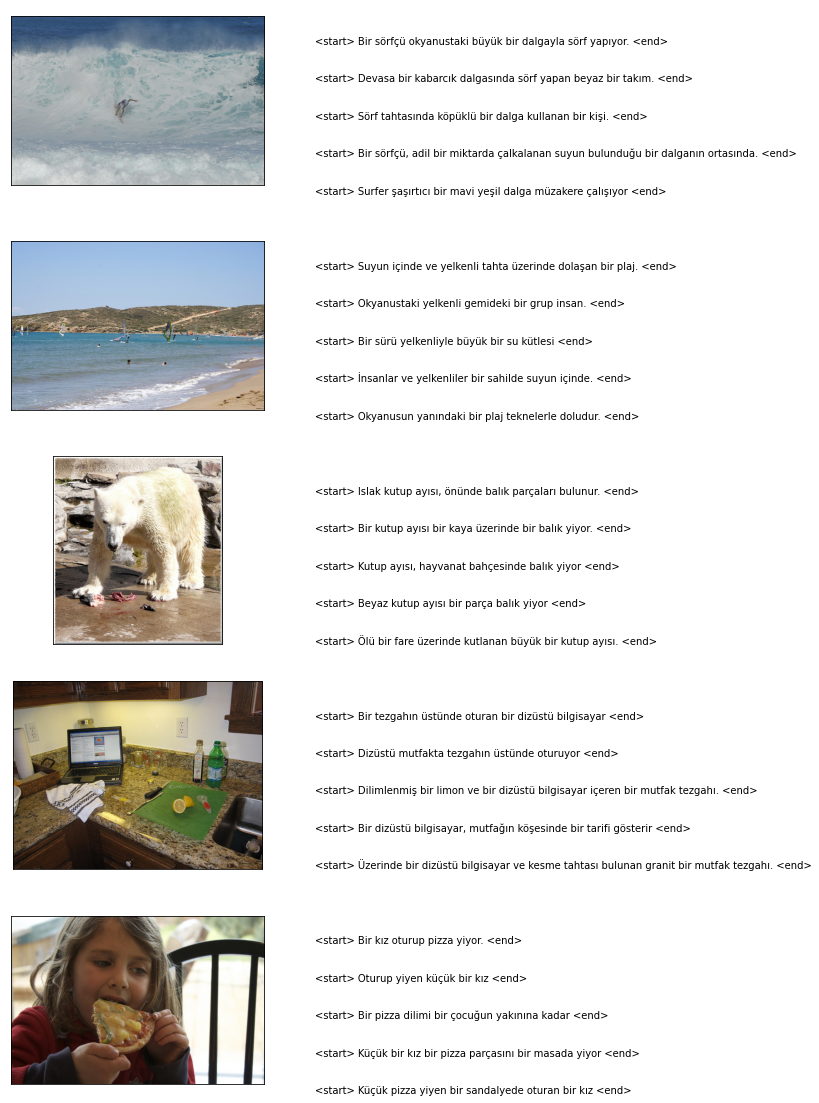

In [ ]:
num_im = 5

count = 1
fig = plt.figure(figsize=(10, 20))
for index in range(0, num_im*num_im, num_im):
    image = img_name_vector[index]
    captions = train_captions[0:num_im*num_im][index::][:num_im]
    ax = fig.add_subplot(num_im, 2, count, xticks=[], yticks=[])
    ax.imshow(Image.open(image))
    count += 1
    
    ax = fig.add_subplot(num_im, 2, count)
    plt.axis('off')
    ax.plot()
    ax.set_xlim(0, 1)
    ax.set_ylim(0, len(captions))
    for i, caption in enumerate(captions):
        ax.text(0, i, caption, fontsize=10)
    count += 1

plt.show()

### Preprocess the images using pretrained CNN model


In [ ]:
# All pretrained keras models
# densenet, efficientnet, imagenet_utils, inception_resnet_v2, inception_v3, mobilenet, mobilenet_v2, mobilenet_v3, nasnet, resnet, resnet50, resnet_v2, vgg16, vgg19, xception

In [ ]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.keras.layers.Resizing(299, 299)(img)
    img = tf.keras.applications.inception_v3.preprocess_input(img) 
    
    return img, image_path

Initialize CNN and load the pretrained Imagenet weights

Çıktı katmanının kullanılan CNN mimarisindeki son evrişim katmanının olduğu bir tf.keras modeli oluşturulur. Bu katmanın çıktısı attention yöntemi ile birleştirilir. 




In [ ]:
image_model = tf.keras.applications.InceptionV3(include_top=False,
                                                weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

87924736/87910968 [==============================] - 1s 0us/step


### Caching the features extracted from pretrained CNN model




Her görüntüyü seçilen CNN modeli ile önceden işleyerek önbelleğe kaydedelim.

In [ ]:
# Get unique images
encode_train = sorted(set(img_name_vector))

# Feel free to change batch_size according to your system configuration
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(
    load_image, num_parallel_calls=tf.data.AUTOTUNE).batch(16)

for img, path in image_dataset:
    batch_features = image_features_extract_model(img)
    batch_features = tf.reshape(batch_features,
                                (batch_features.shape[0], -1, 
                                 batch_features.shape[3]))

    for bf, p in zip(batch_features, path):
        path_of_feature = p.numpy().decode("utf-8")
        np.save(path_of_feature, bf.numpy())

### Preprocess and tokenize the captions



Metin başlıklarını aşağıdaki adımlarla birlikte [TextVectorization](https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization) katmanını kullanarak tamsayı dizesine dönüştürelim: * Tüm görüntü altyazılarını yinelemek, görüntü açıklamalarını kelimelere bölmek ve en iyi 5.000 kelimenin (bir kelime dağarcığını) hesaplamak için [adapt](https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization#adapt) kullanalım.

* Her kelimeyi kelime dağarcığındaki diziniyle eşleştirerek tüm görüntü altyazılarını belirtelim.
* Sonuçları görüntülemek için kelimeden dizine ve dizin/kelime eşleştirmelerini oluşturalım.

In [ ]:
caption_dataset = tf.data.Dataset.from_tensor_slices(train_captions)

# We will override the default standardization of TextVectorization to preserve
# "<>" characters, so we preserve the tokens for the <start> and <end>.
def standardize(inputs):
    inputs = tf.strings.lower(inputs)
    return tf.strings.regex_replace(inputs,
                                    r"!\"#$%&\(\)\*\+.,-/:;=?@\[\\\]^_`{|}~", "")

# Max word count for a caption.
max_length = 50
# Use the top 5000 words for a vocabulary.
vocabulary_size = 5000
tokenizer = tf.keras.layers.TextVectorization(
    max_tokens=vocabulary_size,
    standardize=standardize,
    output_sequence_length=max_length)
# Learn the vocabulary from the caption data.
tokenizer.adapt(caption_dataset)

In [ ]:
# Create the tokenized vectors
cap_vector = caption_dataset.map(lambda x: tokenizer(x))
# For create a cap_vector split
img2cap_vector = []
for cap in cap_vector:
    img2cap_vector.append(cap)

In [ ]:
# Create mappings for words to indices and indicies to words.
word2index = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary())
index2word = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary(),
    invert=True)

### Split the data into training and testing

Rastgele seçilen veri kümesinin %80'i eğitim geri kalan %20'si doğrulama kümesi olacak şekilde bölelim.

In [ ]:
img_name_train, img_name_val, cap_train, cap_val = train_test_split(img_name_vector,
                                                                    img2cap_vector,
                                                                    test_size=0.2,
                                                                    random_state=seed)

len(img_name_train), len(cap_train), len(img_name_val), len(cap_val)

### Create a tf.data dataset for training


Görüntüler ve altyazılar eğitim ve doğrulama aşaması için hazır! Ardından, modellerimizi eğitmekte kullanmak üzere bir 'tf.data' veri kümesi oluşturalım.

In [ ]:
# Feel free to change these parameters according to your system's configuration

BATCH_SIZE = 64
BUFFER_SIZE = 1000
embedding_dim = 256
units = 512
num_steps = len(img_name_train) // BATCH_SIZE
# Shape of the vector extracted from InceptionV3 is (64, 2048)
# These two variables represent that vector shape
attention_features_shape, features_shape = batch_features.shape[1:]

In [ ]:
# Load the numpy files
def map_func(img_name, cap):
    img_tensor = np.load(img_name.decode('utf-8') + '.npy')
    return img_tensor, cap

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

# Use map to load the numpy files in parallel
train_dataset = train_dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int64]),
          num_parallel_calls=tf.data.AUTOTUNE)

# Shuffle and batch
train_dataset = train_dataset.shuffle(BUFFER_SIZE, seed=seed).batch(BATCH_SIZE)
train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
val_dataset = tf.data.Dataset.from_tensor_slices((img_name_val, cap_val))

# Use map to load the numpy files in parallel
val_dataset = val_dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int64]),
          num_parallel_calls=tf.data.AUTOTUNE)

# Shuffle and batch
val_dataset = val_dataset.shuffle(BUFFER_SIZE, seed=seed).batch(BATCH_SIZE)
val_dataset = val_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

## CNN + RNN Model

Model mimarisi: [Show, Attend and Tell: Neural Image Caption Generation with Visual Attention](https://arxiv.org/abs/1502.03044).


Xu, Kelvin, et al. "Show, attend and tell: Neural image caption generation with visual attention." International conference on machine learning. PMLR, 2015.

In [ ]:
class BahdanauAttention(tf.keras.Model):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, features, hidden):
        hidden_with_time_axis = tf.expand_dims(hidden, 1)

        attention_hidden_layer = (tf.nn.tanh(self.W1(features) +
                                         self.W2(hidden_with_time_axis)))

        score = self.V(attention_hidden_layer)

        attention_weights = tf.nn.softmax(score, axis=1)

        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

class CNN_Encoder(tf.keras.Model):
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

class RNN_Decoder(tf.keras.Model):
    def __init__(self, embedding_dim, units, vocab_size):
        super(RNN_Decoder, self).__init__()
        self.units = units

        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
        self.fc1 = tf.keras.layers.Dense(self.units)
        self.fc2 = tf.keras.layers.Dense(vocab_size)

        self.attention = BahdanauAttention(self.units)

    def call(self, x, features, hidden):
        context_vector, attention_weights = self.attention(features, hidden)

        x = self.embedding(x)

        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

        output, state = self.gru(x)

        x = self.fc1(output)

        x = tf.reshape(x, (-1, x.shape[2]))

        x = self.fc2(x)

        return x, state, attention_weights

    def reset_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

In [ ]:
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, tokenizer.vocabulary_size())

In [ ]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=10000,
    decay_rate=0.9)

optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, 
    reduction='none')


def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    return tf.reduce_mean(loss_)


accuracy_function = tf.keras.metrics.SparseCategoricalAccuracy(
    name='accuracy_function')

### Checkpoint

In [ ]:
checkpoint_path = "./checkpoints/train"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer=optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [ ]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
    # restoring the latest checkpoint in checkpoint_path
    ckpt.restore(ckpt_manager.latest_checkpoint)

### Training & test loop from scratch



* Extract the features stored in the respective `.npy` files and then pass those features through the encoder.
* The encoder output, hidden state(initialized to 0) and the decoder input (which is the start token) is passed to the decoder.
* The decoder returns the predictions and the decoder hidden state.
* The decoder hidden state is then passed back into the model and the predictions are used to calculate the loss.
* Use teacher forcing to decide the next input to the decoder.
* Teacher forcing is the technique where the target word is passed as the next input to the decoder.
* The final step is to calculate the gradients and apply it to the optimizer and backpropagate.


In [ ]:
@tf.function
def train_step(encoder, decoder, img_tensor, 
               target, criterion, metrics, optimizer):
    """
    A generic training procedure for one iteration.

    Parameters
    ----------
    encoder
        A convolutional pretrained encoder.
    decoder
        A decoder network RNN and LSTM from scratch.
    img_tensor : tf.Tensor, shape (N, H, W, C)
        A batch of images.
    target : tf.Tensor, shape (1, H, W, C)
        The encoded target caption.
    criterion
        The loss function.
    metrics
        The metric funtion (like accuracy).
    optimizer
        An optimzer.

    Returns
    -------
    loss : tf.Tensor, shape ()
        Total of all losses in the given batch.
    total_loss : tf.Tensor, shape ()
        The average loss for the batch.
    accuracy : tf.Tensor, shape()
        Total of all accuracy in the given batch.
    total_accuracy : tf.Tensor, shape ()
        The average accuracy for the batch.
    """
    loss = 0
    accuracy = 0

    # initializing the hidden state for each batch
    # because the captions are not related from image to image
    hidden = decoder.reset_state(batch_size=target.shape[0])

    dec_input = tf.expand_dims([word2index('<start>')] * target.shape[0], 1)

    with tf.GradientTape() as tape:
        features = encoder(img_tensor)

        for i in range(1, target.shape[1]):
            # passing the features through the decoder
            predictions, hidden, _ = decoder(dec_input, features, hidden)

            loss += criterion(target[:, i], predictions)
            accuracy += metrics(target[:, i], predictions)

            # using teacher forcing
            dec_input = tf.expand_dims(target[:, i], 1)

    total_loss = (loss / int(target.shape[1]))
    total_accuracy = (accuracy / int(target.shape[1]))

    trainable_variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, trainable_variables)
    optimizer.apply_gradients(zip(gradients, trainable_variables))

    return loss, total_loss, accuracy, total_accuracy


@tf.function
def test_step(encoder, decoder, img_tensor, 
               target, criterion, metrics):
    """
    A generic testing procedure.

    Parameters
    ----------
    encoder
        A convolutional pretrained encoder.
    decoder
        A decoder network RNN and LSTM from scratch.
    img_tensor : tf.Tensor, shape (N, H, W, C)
        A batch of images.
    target : tf.Tensor, shape (1, H, W, C)
        The encoded target caption.
    criterion
        The loss function.
    metrics
        The metric funtion (like accuracy).

    Returns
    -------
    total_loss : tf.Tensor, shape ()
        The average loss for the batch.
    total_accuracy : tf.Tensor, shape ()
        The average accuracy for the batch.
    """
    loss = 0
    accuracy = 0

    hidden = decoder.reset_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([word2index('<start>')] * target.shape[0], 1)
    features = encoder(img_tensor)

    for i in range(1, target.shape[1]):
        predictions, hidden, _ = decoder(dec_input, features, hidden)

        loss += criterion(target[:, i], predictions)
        accuracy += metrics(target[:, i], predictions)

    total_loss = (loss / int(target.shape[1]))
    total_accuracy = (accuracy / int(target.shape[1]))

    return total_loss, total_accuracy

In [ ]:
EPOCHS = 25 
verbose = True

# adding this in a separate cell because if you run the training cell
# many times, the loss_plot array will be reset
# train_losses = tf.keras.metrics.Mean(name='train_losses')
# val_losses = tf.keras.metrics.Mean(name='val_losses')
# train_losses.update_state(total_train_loss / num_steps)
# val_losses.update_state(total_val_loss / num_steps)

train_losses = []
val_losses = []

for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_train_loss = 0
    total_train_acc = 0
    
    print('==== Epoch #{0:3d} ===='.format(epoch + 1))

    for (batch, (img_tensor, target)) in enumerate(train_dataset):
        batch_loss, train_loss, batch_acc, train_acc = train_step(
            encoder, decoder, img_tensor, target,loss_function, 
            accuracy_function, optimizer)
        
        total_train_loss += train_loss
        total_train_acc += train_acc

        if batch % 100 == 0:
            average_batch_loss = batch_loss.numpy()/int(target.shape[1])
            average_batch_acc = batch_acc.numpy()/int(target.shape[1])
            print(f'In the current epoch, batch: {batch}, loss: {average_batch_loss:.4f}, accuracy: {average_batch_acc:.4f}')
    # storing the epoch end loss value to plot later
    train_losses.append(total_train_loss / num_steps)

    if epoch % 5 == 0:
      ckpt_manager.save()

    # Run a validation loop at the end of each epoch.
    total_val_loss = 0
    total_val_acc = 0
    for img_tensor, target in val_dataset:
        val_loss, val_acc = test_step(
            encoder, decoder, img_tensor, target, 
            loss_function, accuracy_function)
        
        total_val_loss += val_loss
        total_val_acc += val_acc

    val_losses.append(total_val_loss / num_steps)

    if verbose:
        print(f'Training loss: {total_train_loss / num_steps:.6f}, accuracy: {total_train_acc / num_steps:.6f}')
        print(f'Validation loss: {total_val_loss / num_steps:.6f}, accuracy: {total_val_acc / num_steps:.6f}')
        print(f'Time taken for 1 epoch {time.time()-start:.2f} sec\n')

==== Epoch #  1 ====
In the current epoch, batch: 0, loss: 3.0650, accuracy: 0.0406
In the current epoch, batch: 100, loss: 1.0544, accuracy: 0.0390
In the current epoch, batch: 200, loss: 0.9516, accuracy: 0.0391
In the current epoch, batch: 300, loss: 0.9216, accuracy: 0.0396
Training loss: 0.987038, accuracy: 0.039400
Validation loss: 0.284377, accuracy: 0.009848
Time taken for 1 epoch 240.87 sec

==== Epoch #  2 ====
In the current epoch, batch: 0, loss: 0.9197, accuracy: 0.0386
In the current epoch, batch: 100, loss: 0.8609, accuracy: 0.0395
In the current epoch, batch: 200, loss: 0.8491, accuracy: 0.0403
In the current epoch, batch: 300, loss: 0.8097, accuracy: 0.0412
Training loss: 0.837866, accuracy: 0.040206
Validation loss: 0.291113, accuracy: 0.010319
Time taken for 1 epoch 216.42 sec

==== Epoch #  3 ====
In the current epoch, batch: 0, loss: 0.7166, accuracy: 0.0407
In the current epoch, batch: 100, loss: 0.7460, accuracy: 0.0415
In the current epoch, batch: 200, loss: 0.7

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=np.arange(EPOCHS), 
                        y=train_losses,
                        name='Train Loss',
                        marker_symbol='star-dot'))


fig.add_trace(go.Scatter(x=np.arange(EPOCHS), 
                        y=val_losses,
                        name='Validation Loss',
                        marker_symbol='diamond-wide-open-dot'))


fig.update_layout(
    title='Loss Curves',
    title_font_size=16,
    yaxis_title="Loss",
    xaxis_title="#Num of Epoch",
    width=600)

fig.show()

### Evaluation


In [ ]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0],
                                                 -1,
                                                 img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([word2index('<start>')], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input,
                                                         features,
                                                         hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        predicted_word = tf.compat.as_text(index2word(predicted_id).numpy())
        result.append(predicted_word)

        if predicted_word == '<end>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

In [ ]:
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(10, 10))

    len_result = len(result)
    for i in range(len_result):
        temp_att = np.resize(attention_plot[i], (8, 8))
        grid_size = max(int(np.ceil(len_result/2)), 2)
        ax = fig.add_subplot(grid_size, grid_size, i+1)
        ax.set_title(result[i])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

Real Caption: <start> beyaz bir gömlekli bir adam, yiyeceklerini [UNK] çıkarıyor. <end>
Prediction Caption: bir [UNK] bir [UNK] bir kişi bira ve bira içen bir adam. <end>


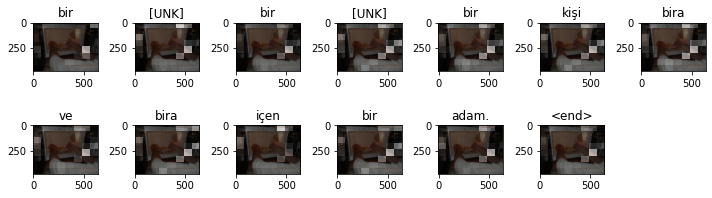

In [ ]:
# captions on the validation set
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
real_caption = ' '.join([tf.compat.as_text(index2word(i).numpy())
                         for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)

print('Real Caption:', real_caption)
print('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)

## CNN + Transformers Model

Benzer model mimarisi: [CPTR: FULL TRANSFORMER NETWORK FOR IMAGE CAPTIONING](https://arxiv.org/abs/2101.10804)

Liu, W., Chen, S., Guo, L., Zhu, X., & Liu, J. (2021). Cptr: Full transformer network for image captioning. arXiv preprint arXiv:2101.10804.

In [ ]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
    
        assert d_model % self.num_heads == 0
    
        self.depth = d_model // self.num_heads
        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)
        self.dense = tf.keras.layers.Dense(d_model)
        
    def split_heads(self, x, batch_size):
        """
        Split the last dimension into (num_heads, depth).
        Transpose the result such that the shape is 
        (batch_size, num_heads, seq_len, depth)
        """
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])
    
    def call(self, v, k, q, mask=None):
        batch_size = tf.shape(q)[0]
    
        q = self.wq(q) 
        k = self.wk(k)  
        v = self.wv(v)  
        
        q = self.split_heads(q, batch_size)  
        k = self.split_heads(k, batch_size)  
        v = self.split_heads(v, batch_size)  
        
        scaled_attention, attention_weights = scaled_dot_product_attention(
            q, k, v, mask)
        
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  

        concat_attention = tf.reshape(scaled_attention, 
                                    (batch_size, -1, self.d_model))  

        output = self.dense(concat_attention) 
            
        return output, attention_weights


class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(EncoderLayer, self).__init__()

        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
    
    def call(self, x, training, mask=None):
        attn_output, _ = self.mha(x, x, x, mask)  
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)  

        ffn_output = self.ffn(out1) 
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)  

        return out2


class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(DecoderLayer, self).__init__()

        self.mha1 = MultiHeadAttention(d_model, num_heads)
        self.mha2 = MultiHeadAttention(d_model, num_heads)

        self.ffn = point_wise_feed_forward_network(d_model, dff)
    
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        self.dropout3 = tf.keras.layers.Dropout(rate)
        
        
    def call(self, x, enc_output, training, 
             look_ahead_mask=None, padding_mask=None):

        attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask) 
        attn1 = self.dropout1(attn1, training=training)
        out1 = self.layernorm1(attn1 + x)

        attn2, attn_weights_block2 = self.mha2(
            enc_output, enc_output, out1, padding_mask) 
        attn2 = self.dropout2(attn2, training=training)
        out2 = self.layernorm2(attn2 + out1)  

        ffn_output = self.ffn(out2)  
        ffn_output = self.dropout3(ffn_output, training=training)
        out3 = self.layernorm3(ffn_output + out2) 

        return out3, attn_weights_block1, attn_weights_block2


class Encoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff,
                 row_size,col_size,rate=0.1):
        super(Encoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers
        
        self.embedding = tf.keras.layers.Dense(self.d_model,activation='relu')
        self.pos_encoding = positional_encoding_2d(row_size,col_size, 
                                                self.d_model)
        
        
        self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) 
                        for _ in range(num_layers)]
    
        self.dropout = tf.keras.layers.Dropout(rate)
        
    def call(self, x, training, mask=None):
        seq_len = tf.shape(x)[1]
        
        # adding embedding and position encoding.
        x = self.embedding(x)  
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)
        
        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training, mask)
        
        return x 


class Decoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, 
                 target_vocab_size,
                 maximum_position_encoding, rate=0.1):
        super(Decoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers
        
        self.embedding = tf.keras.layers.Embedding(
            target_vocab_size, d_model)
        self.pos_encoding = positional_encoding_1d(
            maximum_position_encoding, d_model)
        
        self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate) 
                        for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(rate)
        
    def call(self, x, enc_output, training, 
             look_ahead_mask=None, padding_mask=None):

        seq_len = tf.shape(x)[1]
        attention_weights = {}
        
        x = self.embedding(x)  #
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]
        
        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            x, block1, block2 = self.dec_layers[i](x, enc_output, training,
                                                   look_ahead_mask, padding_mask)
      
        attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
        attention_weights['decoder_layer{}_block2'.format(i+1)] = block2
    
        return x, attention_weights


class Transformer(tf.keras.Model):
    def __init__(self, num_layers, d_model, num_heads, dff,
                 row_size,col_size, 
                 target_vocab_size,max_pos_encoding, rate=0.1):
        super(Transformer, self).__init__()

        self.encoder = Encoder(num_layers, d_model, num_heads, 
                               dff, row_size,col_size, rate)

        self.decoder = Decoder(num_layers, d_model, num_heads, dff, 
                               target_vocab_size,max_pos_encoding, rate)

        self.final_layer = tf.keras.layers.Dense(target_vocab_size)
    
    def call(self, inp, tar, training,look_ahead_mask=None, 
             dec_padding_mask=None,enc_padding_mask=None):

        enc_output = self.encoder(inp, training, enc_padding_mask)  
        
        dec_output, attention_weights = self.decoder(
            tar, enc_output, training, 
            look_ahead_mask, dec_padding_mask)
        
        final_output = self.final_layer(dec_output)  
        
        return final_output, attention_weights


class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()
        
        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps
        
    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)
        
        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

### Initialize the model

In [ ]:
# Feel free to change these parameters according to your system's configuration
num_layer = 4
size_model = 512
num_heads = 8
row_size = 8
col_size = 8
dropout_rate = 0.1
learning_rate = CustomSchedule(size_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, 
                                     beta_1=0.9, 
                                     beta_2=0.98, 
                                     epsilon=1e-9)

loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

train_loss = tf.keras.metrics.Mean(name='train_loss')

train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(
    name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')

test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(
    name='test_accuracy')

transformer = Transformer(num_layer, size_model, num_heads,
                          features_shape, row_size, col_size,
                          vocabulary_size, 
                          max_pos_encoding=vocabulary_size+1, 
                          rate=dropout_rate)

### Training & test loop from scratch

In [ ]:
@tf.function
def train_step(transformer, img_tensor, target, 
               criterion, optimizer): 
    """
    A generic training procedure for one iteration.

    Parameters
    ----------
    transformer
        A network transformer from scratch.
    img_tensor : tf.Tensor, shape (N, H, W, C)
        A batch of images.
    target : tf.Tensor, shape (1, H, W, C)
        The encoded target caption.
    criterion
        The loss function.
    optimizer
        An optimzer.
    """
    target_inp = target[:, :-1]
    target_real = target[:, 1:]
  
    dec_mask = create_masks_decoder(target_inp)
  
    with tf.GradientTape() as tape:
        predictions, _ = transformer(img_tensor, target_inp, 
                                     True,  
                                     dec_mask)
        loss = criterion(target_real, predictions)

    gradients = tape.gradient(loss, transformer.trainable_variables)    
    optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))
  
    train_loss(loss)
    train_accuracy(target_real, predictions)
    

@tf.function
def test_step(transformer, img_tensor, 
               target, criterion):
    """
    A generic testing procedure.

    Parameters
    ----------
    transformer
        A transformer network from scratch.
    img_tensor : tf.Tensor, shape (N, H, W, C)
        A batch of images.
    target : tf.Tensor, shape (1, H, W, C)
        The encoded target caption.
    criterion
        The loss function.
    """
    target_inp = target[:, :-1]
    target_real = target[:, 1:]
  
    dec_mask = create_masks_decoder(target_inp)
  
    
    predictions, _ = transformer(img_tensor, target_inp, 
                                 True,
                                 dec_mask)
    
    loss = criterion(target_real, predictions)

    test_loss(loss)
    test_accuracy(target_real, predictions)

In [ ]:
EPOCHS = 25
verbose = True

for epoch in range(EPOCHS):
    start = time.time()
  
    train_loss.reset_states()
    train_accuracy.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()

    print('==== Epoch #{0:3d} ===='.format(epoch + 1))
  
    for (batch, (img_tensor, tar)) in enumerate(train_dataset):
        train_step(transformer, img_tensor, tar, loss_function, optimizer)
        
        if batch % 50 == 0:
            print(f'In the current epoch, batch: {batch}, loss: {train_loss.result():.4f}, accuracy: {train_accuracy.result():.4f}')
      
    # Run a validation loop at the end of each epoch.
    for (batch, (img_tensor, tar)) in enumerate(val_dataset):
        test_step(transformer, img_tensor, tar, loss_function)

    if verbose:
        print ('Training loss: {:.4f}, accuracy: {:.4f}'.format(train_loss.result(), 
                                                                train_accuracy.result()))
        
        print ('Validation loss: {:.4f}, accuracy: {:.4f}'.format(test_loss.result(), 
                                                                test_accuracy.result()))

        print ('Time taken for 1 epoch: {:.4f} sec\n'.format(time.time() - start))

==== Epoch #  1 ====
In the current epoch, batch: 0, loss: 8.6038, accuracy: 0.0000
In the current epoch, batch: 50, loss: 7.9819, accuracy: 0.0153
In the current epoch, batch: 100, loss: 7.4253, accuracy: 0.0210
In the current epoch, batch: 150, loss: 7.0999, accuracy: 0.0249
In the current epoch, batch: 200, loss: 6.8400, accuracy: 0.0286
In the current epoch, batch: 250, loss: 6.6283, accuracy: 0.0312
In the current epoch, batch: 300, loss: 6.4503, accuracy: 0.0334
In the current epoch, batch: 350, loss: 6.3025, accuracy: 0.0352
Training loss: 6.2393, accuracy: 0.0359
Validation loss: 5.3127, accuracy: 0.0471
Time taken for 1 epoch: 256.8705 sec

==== Epoch #  2 ====
In the current epoch, batch: 0, loss: 5.2092, accuracy: 0.0491
In the current epoch, batch: 50, loss: 5.2289, accuracy: 0.0474
In the current epoch, batch: 100, loss: 5.1869, accuracy: 0.0480
In the current epoch, batch: 150, loss: 5.1326, accuracy: 0.0484
In the current epoch, batch: 200, loss: 5.0821, accuracy: 0.0488

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=np.arange(EPOCHS), 
                        y=train_losses,
                        name='Train Loss',
                        marker_symbol='star-dot'))


fig.add_trace(go.Scatter(x=np.arange(EPOCHS), 
                        y=val_losses,
                        name='Validation Loss',
                        marker_symbol='diamond-wide-open-dot'))


fig.update_layout(
    title='Loss Curves',
    title_font_size=16,
    yaxis_title="Loss",
    xaxis_title="#Num of Epoch",
    width=600)

fig.show()

### Evaluation

In [ ]:
def evaluate(image):

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0],
                                                 -1,
                                                 img_tensor_val.shape[3]))


    output = tf.expand_dims([word2index('<start>')], 0)
    result = []

    for i in range(max_length):
        dec_mask = create_masks_decoder(output)
    
        # predictions.shape == (batch_size, seq_len, vocab_size)
        predictions, attention_weights = transformer(img_tensor_val,
                                                     output,
                                                     False,
                                                     dec_mask)
        
        # select the last word from the seq_len dimension
        predictions = predictions[: ,-1:, :]  # (batch_size, 1, vocab_size)

        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int64)
        # return the result if the predicted_id is equal to the end token
        if predicted_id == [word2index('<end>')]:
            return result, tf.squeeze(output, axis=0), attention_weights
        # concatentate the predicted_id to the output which is given to the decoder
        # as its input.
        predicted_word = tf.compat.as_text(index2word(np.asarray(predicted_id).squeeze()).numpy())
        result.append(predicted_word)
        output = tf.concat([output, predicted_id], axis=-1)

    return result, output, attention_weights

BLEU-1 score: 13.667423885313019
BLEU-2 score: 20.877334836498115
BLEU-3 score: 24.73263644462116
BLEU-4 score: 25.802943589457794
Predicted Caption: bir masada bir tabakta bir dilim yiyecek.


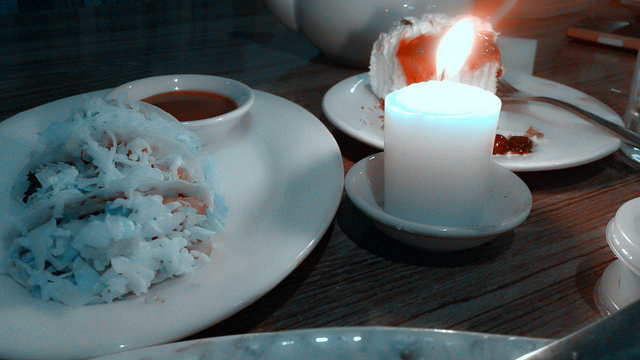

In [ ]:
start_token = word2index(['<start>'])
end_token = word2index(['<end>'])
# select random image from test data
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
real_caption = ' '.join([tf.compat.as_text(index2word(np.asarray(i).squeeze()).numpy()) for i in cap_val[rid] if i not in [0]])
caption, result, attention_weights = evaluate(image)

#remove "<unk>" in result
for i in caption:
    if i=="<unk>":
        caption.remove(i)

for i in real_caption:
    if i=="<unk>":
        real_caption.remove(i)


#print ('Real Caption:', real_caption)
print ('Predicted Caption:', ' '.join(caption))
Image.open(image)

## Analysis

In [ ]:
class COCOEvalCap:
    def __init__(self, images, gts, res):
        self.evalImgs = []
        self.eval = {}
        self.imgToEval = {}
        self.params = {'image_id': images}
        self.gts = gts
        self.res = res

    def evaluate(self):
        imgIds = self.params['image_id']
        gts = self.gts
        res = self.res

        # =================================================
        # Set up scorers
        # =================================================
        print('tokenization...')
        tokenizer = PTBTokenizer()
        gts  = tokenizer.tokenize(gts)
        res = tokenizer.tokenize(res)

        # =================================================
        # Set up scorers
        # =================================================
        print('setting up scorers...')
        scorers = [
            (Bleu(4), ["BLEU_1", "BLEU_2", "BLEU_3", "BLEU_4"]),
            (Meteor(),"METEOR"),
            (Rouge(), "ROUGE_L"),
            (Cider(), "CIDEr")
        ]

        # =================================================
        # Compute scores
        # =================================================
        eval = {}
        for scorer, method in scorers:
            print('computing %s score...'%(scorer.method()))
            score, scores = scorer.compute_score(gts, res)
            if type(method) == list:
                for sc, scs, m in zip(score, scores, method):
                    self.setEval(sc, m)
                    self.setImgToEvalImgs(scs, imgIds, m)
                    print("%s: %0.3f"%(m, sc))
            else:
                self.setEval(score, method)
                self.setImgToEvalImgs(scores, imgIds, method)
                print("%s: %0.3f"%(method, score))
        self.setEvalImgs()

    def setEval(self, score, method):
        self.eval[method] = score

    def setImgToEvalImgs(self, scores, imgIds, method):
        for imgId, score in zip(imgIds, scores):
            if not imgId in self.imgToEval:
                self.imgToEval[imgId] = {}
                self.imgToEval[imgId]["image_id"] = imgId
            self.imgToEval[imgId][method] = score

    def setEvalImgs(self):
        self.evalImgs = [eval for imgId, eval in self.imgToEval.items()]

def calculate_metrics(rng, datasetGTS, datasetRES):
    imgIds = rng
    gts = {}
    res = {}

    imgToAnnsGTS = {ann['image_id']: [] for ann in datasetGTS['annotations']}
    for ann in datasetGTS['annotations']:
        imgToAnnsGTS[ann['image_id']] += [ann]

    imgToAnnsRES = {ann['image_id']: [] for ann in datasetRES['annotations']}
    for ann in datasetRES['annotations']:
        imgToAnnsRES[ann['image_id']] += [ann]

    for imgId in imgIds:
        gts[imgId] = imgToAnnsGTS[imgId]
        res[imgId] = imgToAnnsRES[imgId]

    evalObj = COCOEvalCap(imgIds,gts,res)
    evalObj.evaluate()
    return evalObj.eval

if __name__ == '__main__':
    rng = range(2)
    datasetGTS = {'annotations': []}
    datasetRES = {'annotations': []}
    
    for index, image in enumerate(img_name_val):
        real_caption = ' '.join([tf.compat.as_text(
            index2word(np.asarray(i).squeeze()).numpy()) for i in cap_val[index] if i not in [0]])
        caption, result, attention_weights = evaluate(image)

        for i in caption:
            if i=="<unk>":
                caption.remove(i)

        for i in real_caption:
            if i=="<unk>":
                real_caption.remove(i)
            
        result_join = ' '.join(caption)
        result_final = result_join.rsplit(' ', 1)[0]
        gnd = {}
        pred = {}

        gnd['image_id'] = index
        gnd['caption'] = real_caption
        datasetGTS['annotations'].append(gnd)        
        pred['image_id'] = index
        pred['caption'] = result_final
        datasetRES['annotations'].append(pred)

    scores = calculate_metrics(rng, datasetGTS, datasetRES)

tokenization...
setting up scorers...
computing Bleu score...
{'testlen': 9, 'reflen': 11, 'guess': [9, 7, 5, 3], 'correct': [8, 5, 3, 1]}
ratio: 0.8181818181074382
Bleu_1: 0.712
Bleu_2: 0.638
Bleu_3: 0.580
Bleu_4: 0.478
computing METEOR score...
METEOR: 0.402
computing Rouge score...
ROUGE_L: 0.786
computing CIDEr score...
CIDEr: 4.017
{'Bleu_1': 0.711766580212326, 'Bleu_2': 0.638042834868279, 'Bleu_3': 0.5804707570883624, 'Bleu_4': 0.47799953528030814, 'METEOR': 0.40192687755977896, 'ROUGE_L': 0.7860759493670886, 'CIDEr': 4.016678075227614}


In [ ]:
keys = list(scores.keys())
values_rnn = list(scores.values())
values_rnn.insert(0, 'CNN + RNN')
values_transformer = list(scores.values())
values_transformer.insert(0, 'CNN + Transformer')

table = [keys, 
         values_rnn,
         values_transformer]

print(tabulate(table, headers='firstrow', tablefmt='fancy_grid', floatfmt='.4f'))

╒═══════════════════╤══════════╤══════════╤══════════╤══════════╤══════════╤═══════════╤═════════╕
│                   │   BLEU_1 │   BLEU_2 │   BLEU_3 │   BLEU_4 │   METEOR │   ROUGE_L │   CIDEr │
╞═══════════════════╪══════════╪══════════╪══════════╪══════════╪══════════╪═══════════╪═════════╡
│ CNN + Transformer │   0.1714 │   0.2416 │   0.3258 │   0.3551 │   0.0520 │    0.1697 │  0.1767 │
├───────────────────┼──────────┼──────────┼──────────┼──────────┼──────────┼───────────┼─────────┤
│ CNN + RNN         │   0.1506 │   0.0247 │   0.0557 │   0.0139 │   0.0126 │    0.0629 │  0.0798 │
╘═══════════════════╧══════════╧══════════╧══════════╧══════════╧══════════╧═══════════╧═════════╛


In [ ]:
fig = go.Figure()
fig.add_trace(go.Bar(
    x=keys,
    y=transformer_scores,
    error_y=dict(type='data', array=std_transformer),
    name='CNN + Transformer'
))

fig.add_trace(go.Bar(
    x=keys,
    y=rnn_scores,
    error_y=dict(type='data', array=std_rnn),
    name='CNN + RNN'
))

fig.update_layout(
    title_text='',
    showlegend=True,
    yaxis=dict(
        title="Scores",
        showgrid=False,
        showline=False,
        showticklabels=True,
    ),
    xaxis=dict(
        title="Metrics",
        zeroline=False,
        showline=False,
        showticklabels=True,
        showgrid=True,
        tickvals = keys,
        ticks="outside",
        tickson="boundaries",
        ticklen=5
    ),
    width=750,
    height=500)
fig.show()

## Try it on your own images

Eğlence için, aşağıda, eğitilen modelle kendi görüntülerinizi altyazılamak için kullanabileceğiniz bir yöntem sağlanır. Unutmayın, nispeten az miktarda veri üzerinde eğitildi ve görüntüler eğitim verilerinden oldukça farklı olabilir (bu yüzden garip sonuçlara hazırlıklı olun!)


In [ ]:
# paste to your image url for predict caption
image_url = 'https://tensorflow.org/images/surf.jpg'
image_extension = image_url[-4:]
image_path = tf.keras.utils.get_file('image' + image_extension, origin=image_url)

# act with the function of the model you last used 
result, attention_plot = evaluate(image_path)
print('Prediction Caption:', ' '.join(result))
plot_attention(image_path, result, attention_plot)
Image.open(image_path)

Prediction Caption: [UNK] [UNK] bir uçak. <end>


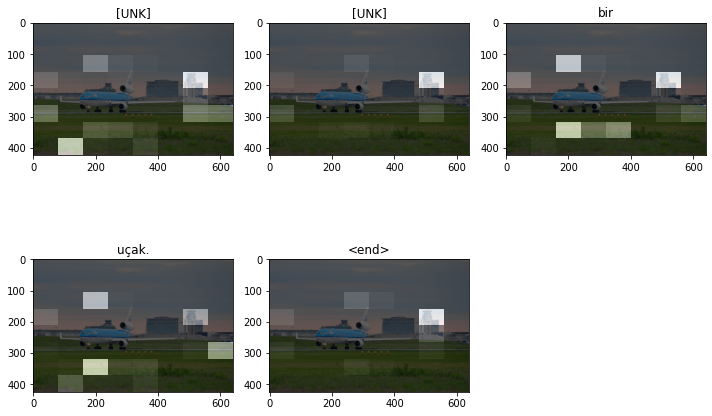

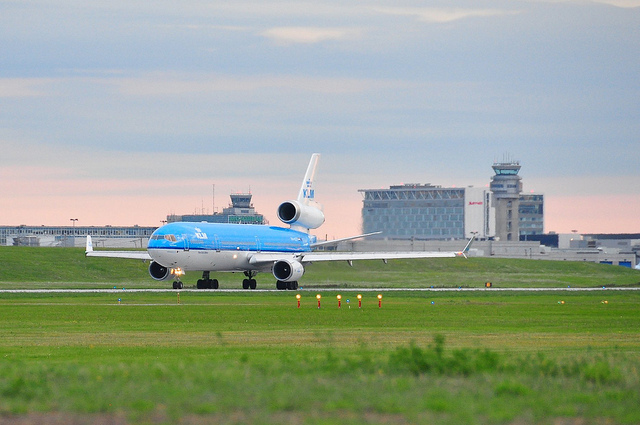

In [ ]:
#@title Try the trained model from COCO dataset

IMAGE_NAME = "106364" #@param ["106364", "181103", "204509", "318990", "347603", "188443", "134755"]

name_ = "COCO_train2014_000000" + IMAGE_NAME + ".jpg"
image_path = os.path.join(os.path.dirname('/content/'), "train2014/") + name_

result, attention_plot = evaluate(image_path)
print('Prediction Caption:', ' '.join(result))
plot_attention(image_path, result, attention_plot)
# opening the image
Image.open(image_path)

# References





*   [Training loop from scratch](https://keras.io/guides/writing_a_training_loop_from_scratch/)

*   [Train the keras model](https://towardsdatascience.com/write-a-custom-training-routine-for-your-keras-model-a9139312a8a9)

*   [Tensorflow training loop](https://towardsdatascience.com/model-sub-classing-and-custom-training-loop-from-scratch-in-tensorflow-2-cc1d4f10fb4e)

*   [Tensorflow guide for keras training loop](https://www.tensorflow.org/guide/keras/writing_a_training_loop_from_scratch)
